In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
import lightgbm as lgb

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns

path_root = '../input/optiver-realized-volatility-prediction'
path_data = '../input/optiver-realized-volatility-prediction'
path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def get_stock_stat(stock_id : int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    #Book features
    df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] +
                                    df_book['ask_price1'] * df_book['bid_size1']) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] +
                                    df_book['ask_price2'] * df_book['bid_size2']) / (df_book['bid_size2'] + df_book['ask_size2'])
    df_book['log_return1'] = df_book.groupby(by = ['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by = ['time_id'])['wap2'].apply(log_return).fillna(0)
    
    features_to_apply_realized_volatility = ['log_return'+str(i+1) for i in range(2)]
    stock_stat = df_book.groupby(by = ['stock_id', 'time_id'])[features_to_apply_realized_volatility]\
                        .agg(realized_volatility).reset_index()

    #Trade features
    trade_stat =  pd.read_parquet(os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id)))
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return1'] = trade_stat.groupby(by = ['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by = ['stock_id', 'time_id'])[['trade_log_return1']]\
                           .agg(realized_volatility).reset_index()
    #Joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    
    return stock_stat

def get_dataSet(stock_ids : list, dataType = 'train'):

    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    
    stock_stat_df = pd.concat(stock_stat, ignore_index = True)

    return stock_stat_df

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'objective': 'regression',
        'metric': 'None',
        'max_depth': -1,
        'n_jobs': -1,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'lambda_l2': 1,
        'verbose': -1
        #'bagging_freq': 5
}

## Train and test datasets

In [3]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))
%time train_stock_stat_df = get_dataSet(stock_ids = train['stock_id'].unique(), dataType = 'train')
train = pd.merge(train, train_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left')
print('Train shape: {}'.format(train.shape))
display(train.head(2))

test = pd.read_csv(os.path.join(path_data, 'test.csv'))
test_stock_stat_df = get_dataSet(stock_ids = test['stock_id'].unique(), dataType = 'test')
test = pd.merge(test, test_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left').fillna(0)
print('Test shape: {}'.format(test.shape))
display(test.head(2))

CPU times: user 1.44 s, sys: 138 ms, total: 1.58 s
Wall time: 7min 9s
Train shape: (428932, 6)


,stock_id,time_id,target,log_return1,log_return2,trade_log_return1
0,0,5,0.004136,0.004499,0.006999,0.002006
1,0,11,0.001445,0.001204,0.002476,0.000901


Test shape: (3, 6)


,stock_id,time_id,row_id,log_return1,log_return2,trade_log_return1
0,0,4,0-4,0.000294,0.000252,0.000295
1,0,32,0-32,0.000000,0.000000,0.000000


## Training model and making predictions

We consider 4 features
CV 1/4


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.24967
[500]	valid_0's RMSPE: 0.2449
[750]	valid_0's RMSPE: 0.24496
[1000]	valid_0's RMSPE: 0.24489
[1250]	valid_0's RMSPE: 0.24517
[1500]	valid_0's RMSPE: 0.24549
Early stopping, best iteration is:
[1059]	valid_0's RMSPE: 0.24479
Fold 1 lgb1: 0.24479
CV 2/4
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25097
[500]	valid_0's RMSPE: 0.24576
[750]	valid_0's RMSPE: 0.24572
[1000]	valid_0's RMSPE: 0.24595
Early stopping, best iteration is:
[696]	valid_0's RMSPE: 0.24567
Fold 2 lgb1: 0.24567
CV 3/4
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25056
[500]	valid_0's RMSPE: 0.24556
[750]	valid_0's RMSPE: 0.24562
[1000]	valid_0's RMSPE: 0.24582
Early stopping, best iteration is:
[608]	valid_0's RMSPE: 0.24552
Fold 3 lgb1: 0.24552
CV 4/4
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25732


,row_id,target
0,0-4,0.000755
1,0-32,0.000740


Text(0, 0.5, 'Feature')

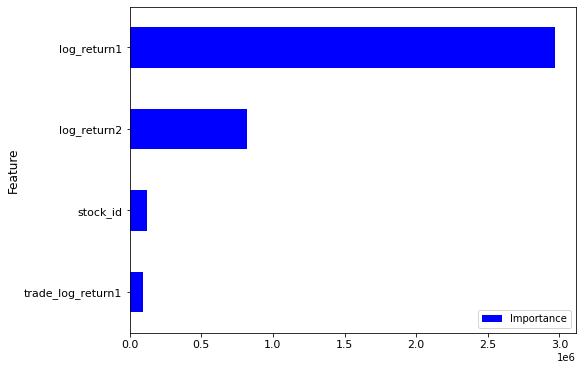

In [4]:
cats = ['stock_id']
model_name = 'lgb1'
pred_name = 'pred_{}'.format(model_name)
features_to_consider = ['stock_id', 'log_return1', 'log_return2', 'trade_log_return1']
print('We consider {} features'.format(len(features_to_consider)))

train[pred_name] = 0
test['target'] = 0

n_folds = 4
n_rounds = 5000
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2016)
scores_folds[model_name] = []
counter = 1
for dev_index, val_index in kf.split(range(len(train))):
    print('CV {}/{}'.format(counter, n_folds))
    X_train = train.loc[dev_index, features_to_consider]
    y_train = train.loc[dev_index, target_name].values
    X_val = train.loc[val_index, features_to_consider]
    y_val = train.loc[val_index, target_name].values
    
    #############################################################################################
    #LGB
    #############################################################################################
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cats, weight=1/np.power(y_train,2))
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cats, weight=1/np.power(y_val,2))
    
    model = lgb.train(params_lgbm, 
                      train_data, 
                      n_rounds, 
                      valid_sets=val_data, 
                      feval=feval_RMSPE,
                      verbose_eval= 250,
                      early_stopping_rounds=500
                     )
    preds = model.predict(train.loc[val_index, features_to_consider])
    train.loc[val_index, pred_name] = preds
    score = round(rmspe(y_true = y_val, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    counter += 1
    test[target_name] += model.predict(test[features_to_consider]).clip(0,1e10)
del train_data, val_data
test[target_name] = test[target_name]/n_folds

score = round(rmspe(y_true = train[target_name].values, y_pred = train[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test[['row_id', target_name]].head(2))
test[['row_id', target_name]].to_csv('submission.csv',index = False)

importances = pd.DataFrame({'Feature': model.feature_name(), 
                            'Importance': model.feature_importance(importance_type='gain')})
importances.sort_values(by = 'Importance', inplace=True)
importances2 = importances.nlargest(50,'Importance', keep='first').sort_values(by='Importance', ascending=True)
importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)